In [ ]:
# Plot the output of ddcurves

In [1]:
import h5py
import numpy as np
import pandas as pd
import xarray as xr
from datetime import datetime
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid.inset_locator import inset_axes
#from mpl_toolkits.axisartist.
from matplotlib.collections import LineCollection

from glob import glob

/home/suntans/.conda/envs/soda/lib/python3.6/site-packages/mpl_toolkits/axes_grid/__init__.py:12: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid module was deprecated in Matplotlib 2.1 and will be removed two minor releases later. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist, which provide the same functionality instead.
  obj_type='module')


In [2]:
#%matplotlib inline

In [3]:
#%matplotlib inline

plt.rcParams.update({'font.size': 18})
plt.rcParams.update({'axes.labelsize':'large'})

In [4]:
def double_tanh_6(beta, z):
    
    return beta[0,...] - beta[1,...]*(np.tanh((z+beta[2,...])/beta[3,...])
                + np.tanh((z+beta[2,...] + beta[4,...])/beta[5,...]))

def double_tanh(beta, z):
    
    return beta[0,...] - beta[1,...]*(np.tanh((z+beta[2,...])/beta[3,...])
                + np.tanh((z+beta[4,...])/beta[5,...]))

def single_tanh(beta, z):
    
    return beta[0,...] - beta[1,...]* np.tanh((z+beta[2,...])/beta[3,...])


In [5]:
def load_density_h5(h5file):
    f = h5py.File(h5file,'r')
    rho = f['data/rho'][:]
    depth = f['data/z'][:]
    timeidx = f['data/timeidx'][:]

    data = f['beta_samples'][:]
    time = f['data/time'][:].astype('<M8[ns]')
    rho_std = f['data/rho_std'].value
    rho_mu = f['data/rho_mu'].value
    z_std = f['data/z_std'].value
    f.close()
    return data,time, rho, depth, timeidx, rho_std, z_std, rho_mu

In [131]:
###########
# Inputs
#datadir = '/home/suntans/cloudstor/Data/IMOS/'
datadir = '../../run_ddcurves/DATA_SHELL/'

#sitename = 'KP150_12mth_dht_pymc3'
#nparams=6
#ncfile = '%sCrux_KP150_12mth_Density_lowpass_density_bhm_6params_2018-12-19_nliw.nc'%datadir
#density_func = double_tanh_6

#sitename = 'KP150_12mth_filtered_mcmc'
#ncfile = '%s/ShellCrux_Filtered_Density_BHM_MCMC_20162017_nliw.nc'%datadir
#h5file = '%s/ShellCrux_Filtered_Density_BHM_MCMC_20162017.h5'%datadir
#density_func = double_tanh
#nparams=6

#sitename = 'KP150_12mth_filtered_vi'
#ncfile = '%s/ShellCrux_Filtered_Density_BHM_VI_20162017_nliw.nc'%datadir
#h5file = '%s/ShellCrux_Filtered_Density_BHM_VI_20162017.h5'%datadir
#density_func = double_tanh
#nparams=6

sitename = 'KP150_12mth_unfiltered_vi'
#ncfile = '%s/ShellCrux_Uniltered_Density_BHM_VI_20162017_nliw.nc'%datadir
ncfile = '%s/ShellCrux_Uniltered_Density_BHM_VI_20162017_vkdv_nliw.nc'%datadir
h5file = '%s/ShellCrux_Uniltered_Density_BHM_VI_20162017.h5'%datadir
density_func = double_tanh
nparams = 6

# 
z_mu = 0.
z_std = 100.
rho_std = 1.5
rho_mu = 1024


#sitename = 'KP150_12mth_sht_pymc3'
#nparams=4
#ncfile = '../../run-ddcurves/DATA_SHELL/Crux_KP150_12mth_Density_lowpass_density_bhm_4params_2018-12-18_nliw.nc'
#density_func = single_tanh

#sitename = 'KP150_12mth_dht_stan'
#nparams=6
#ncfile = '../../run-ddcurves/DATA_SHELL/Crux_KP150_12mth_Density_lowpass_nliw.nc'
#density_func = double_tanh

zmin = -252.5
dz = 2.5
outpath = '../FIGURES/'


In [132]:
# List the netcdf files
ds = xr.open_dataset(ncfile)
ds


<xarray.Dataset>
Dimensions:   (ensemble: 500, params: 6, time: 374)
Coordinates:
  * time      (time) datetime64[ns] 2016-04-29T23:15:00 ... 2017-05-07T06:40:00
  * ensemble  (ensemble) int64 0 1 2 3 4 5 6 7 ... 493 494 495 496 497 498 499
  * params    (params) int64 0 1 2 3 4 5
Data variables:
    cn        (time, ensemble) float64 ...
    alpha     (time, ensemble) float64 ...
    beta      (params, time, ensemble) float64 ...
    cn_mu     (time, ensemble) float64 ...
    alpha_mu  (time, ensemble) float64 ...

In [133]:
# Scale the beta parameters
beta_scale = [rho_std, rho_std, z_std, z_std, z_std, z_std]
beta_offset = [rho_mu, 0, z_mu, z_mu, z_mu, z_mu]

for ii in range(nparams):
    ds.beta[ii,:,:] *= beta_scale[ii]
    ds.beta[ii,:,:] += beta_offset[ii]

In [134]:
beta = ds.beta.values
#beta = beta_r # Use the stan values


In [135]:
#nsamples = ds.ensemble.shape[0]
nsamples = 500
ntime = ds.time.shape[0]

# To plot:

 - Isotherm heights
 - beta's w/ credible intervals
 - cn, alpha, Ls

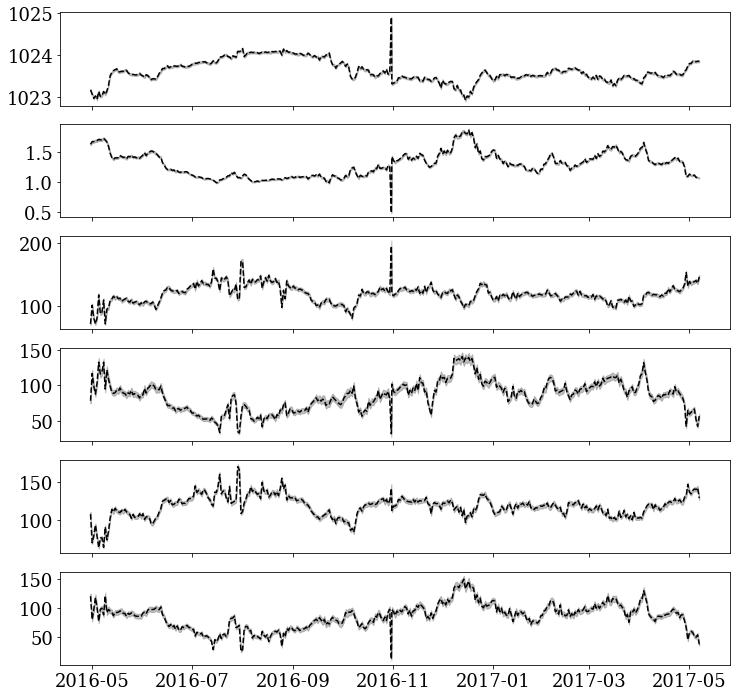

In [136]:
# Beta plot
plt.figure(figsize=(12,12))
for ii in range(nparams):
    
    b50 = np.median(beta[ii,...], axis=-1)
    b5 = np.percentile(beta[ii,...],5.,axis=-1)
    b95 = np.percentile(beta[ii,...],95.,axis=-1)
    
    
    ax = plt.subplot(nparams,1,ii+1)
    plt.fill_between(ds.time.values, b5, y2=b95, color='0.5',alpha=0.5)
    plt.plot(ds.time, b50, 'k--')

    if ii < nparams-1:
        ax.set_xticklabels([])

#plt.savefig('%s/beta_timeseries_%s.png'%(outpath, sitename), dpi=150)
#plt.savefig('%s/beta_timeseries_%s.pdf'%(outpath, sitename), dpi=150)

In [137]:
#zout = np.arange(0, zmin, -dz)[...,np.newaxis].repeat((nsamples,),axis=-1)
z1d = np.arange(0,zmin,-dz)
nz = z1d.shape[0]
zout = z1d[:,np.newaxis,np.newaxis] * np.ones((nz,ntime,nsamples))

In [138]:
rho = density_func(beta[:,0:ntime,0:nsamples],zout)
rho.shape, zout.shape

((101, 374, 500), (101, 374, 500))

In [139]:
# Compute the max N2 and find the depth
N2 = np.gradient(rho,-dz,axis=0) * -9.81/1024.

# Max gradient (pycnocline strength)
N2max = np.amax(N2,axis=0)

# Find the depth of the max (pycnocline depth)
#result = np.where(N2 == N2max)
#idx = np.array(list(zip(result[0], result[1], result[2])))[:,0] # depth index
#zN2max = z1d[idx].reshape(N2max.shape)
zN2max = np.zeros_like(N2max)
for ii in range(N2max.shape[0]):
    for jj in range(N2max.shape[1]):
        idx = np.argwhere(N2[:,ii,jj]==N2max[ii,jj])[0,0]
        zN2max[ii,jj] = z1d[idx]


N2max.shape

(374, 500)

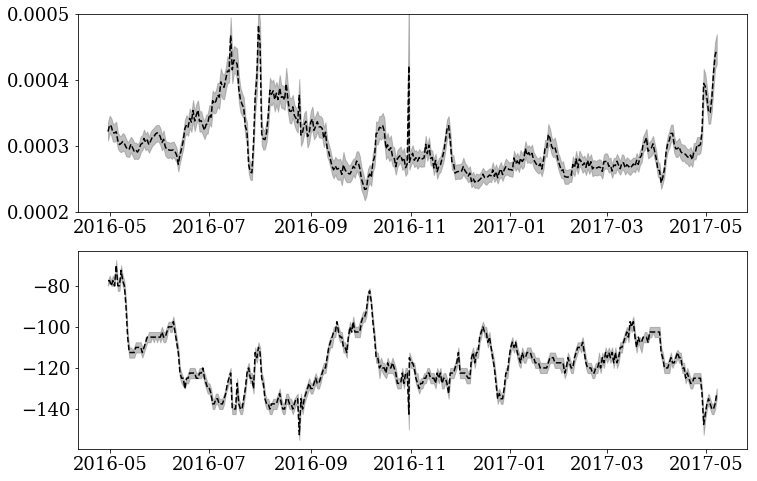

In [140]:
plt.figure(figsize=(12,8))
ax=plt.subplot(211)
plt.plot(ds.time.values, np.median(N2max,axis=1), 'k--')

plt.fill_between(ds.time.values, np.percentile(N2max,2.5,axis=1), \
                 y2=np.percentile(N2max,97.5,axis=1), color='0.5',alpha=0.5)

plt.ylim(2e-4,5e-4)
ax=plt.subplot(212)
plt.plot(ds.time.values, np.median(zN2max,axis=1), 'k--')

plt.fill_between(ds.time.values, np.percentile(zN2max,2.5,axis=1), \
                 y2=np.percentile(zN2max,97.5,axis=1), color='0.5',alpha=0.5)

In [141]:
from soda.utils.isoslice import isoslice

#F = interp1d(rho, z1d, kind='linear', axis=0)

In [142]:
# Compute the mean and credible intervals for isoval heights
isovals = np.arange(1021.000, 1026.5, 0.5)
nrho = isovals.shape[0]

zrho_mean = np.zeros((nrho, ntime))
zrho_95 = np.zeros((nrho, ntime))
zrho_5 = np.zeros((nrho, ntime))

for ii, iso in enumerate(isovals):
    print('Computing isoheights for density %f'%iso)

    isolev = isoslice(zout, rho, iso, axis=0)
   
    idx = isolev.mask
    
    if iso > 1024:
        isolev[idx] = zmin
    else:
        isolev[idx] = 0.

        
    zrho_mean[ii,:] = np.mean(isolev,axis=-1)
    zrho_5[ii,:] = np.percentile(isolev,5,axis=-1)
    zrho_95[ii,:] = np.percentile(isolev,95,axis=-1)

    

Computing isoheights for density 1021.000000


/home/suntans/code/soda/soda/utils/isoslice.py:50: RuntimeWarning: invalid value encountered in true_divide
  result = varl - propl*(varh-varl)/(proph-propl)


Computing isoheights for density 1021.500000
Computing isoheights for density 1022.000000
Computing isoheights for density 1022.500000
Computing isoheights for density 1023.000000
Computing isoheights for density 1023.500000
Computing isoheights for density 1024.000000
Computing isoheights for density 1024.500000
Computing isoheights for density 1025.000000
Computing isoheights for density 1025.500000
Computing isoheights for density 1026.000000


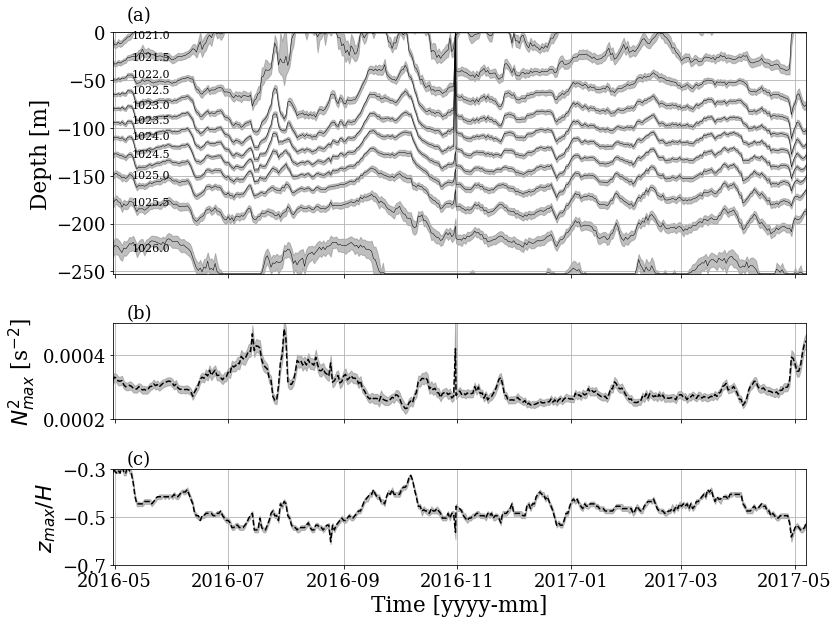

In [143]:
plt.figure(figsize=(12,9))

ax = plt.subplot2grid((4,1),(0,0), rowspan=2)
for ii, iso in enumerate(isovals):
    plt.plot(ds.time.values, zrho_mean[ii,:],'k',lw=0.5)
    plt.fill_between(ds.time.values,  zrho_5[ii,:], y2 = zrho_95[ii,:], color='0.5',alpha=0.5)
    
    plt.text(ds.time.values[10],zrho_5[ii,10],'%3.1f'%iso, fontsize=11)

plt.ylim(zmin,0)
plt.xlim(ds.time.values[0],ds.time.values[-1])
plt.ylabel('Depth [m]')
plt.grid(b=True)
ax.set_xticklabels([])
plt.text(0.02,1.05,'(a)',transform=ax.transAxes)


ax= plt.subplot2grid((4,1),(2,0), rowspan=1)
plt.plot(ds.time.values, np.median(N2max,axis=1), 'k--')

plt.fill_between(ds.time.values, np.percentile(N2max,2.5,axis=1), \
                 y2=np.percentile(N2max,97.5,axis=1), color='0.5',alpha=0.5)

plt.ylim(2e-4,5e-4)
plt.xlim(ds.time.values[0],ds.time.values[-1])
plt.ylabel('$N^2_{max}$ [s$^{-2}$]')
plt.grid(b=True)
ax.set_xticklabels([])
plt.text(0.02,1.05,'(b)',transform=ax.transAxes)


ax= plt.subplot2grid((4,1),(3,0), rowspan=1)
H = 252.5
plt.plot(ds.time.values, np.median(zN2max,axis=1)/H, 'k--')

plt.fill_between(ds.time.values, np.percentile(zN2max/H,2.5,axis=1), \
                 y2=np.percentile(zN2max/H,97.5,axis=1), color='0.5',alpha=0.5)

plt.xlim(ds.time.values[0],ds.time.values[-1])
plt.ylabel('$z_{max}/H$')
plt.ylim(-0.7,-0.3)
plt.xlabel('Time [yyyy-mm]')
plt.yticks([-0.7,-0.5,-0.3])
plt.grid(b=True)
plt.text(0.02,1.05,'(c)',transform=ax.transAxes)

plt.tight_layout()
plt.savefig('%s/ziso_timeseries_%s.png'%(outpath, sitename), dpi=150)
plt.savefig('%s/ziso_timeseries_%s.pdf'%(outpath, sitename), dpi=150)

/home/suntans/.conda/envs/soda/lib/python3.6/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/suntans/.conda/envs/soda/lib/python3.6/site-packages/numpy/lib/function_base.py:3405: RuntimeWarning: Invalid value encountered in median for 1 results
  r = func(a, **kwargs)


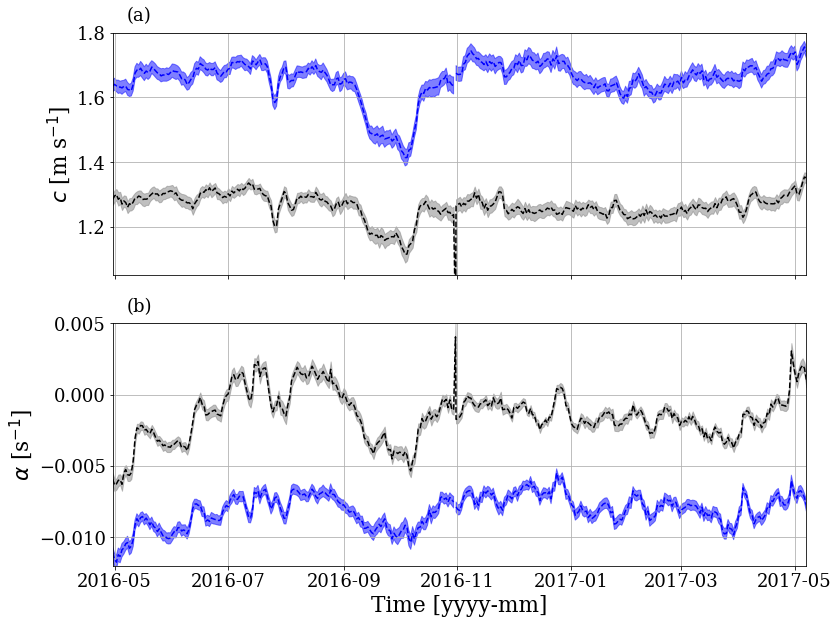

In [154]:
alpha_min = np.percentile(ds.alpha,2.5,axis=1)
alpha_max = np.percentile(ds.alpha,97.5,axis=1)
alpha_50 = np.median(ds.alpha, axis=1)

alpha_mu_min = np.percentile(ds.alpha_mu,2.5,axis=1)
alpha_mu_max = np.percentile(ds.alpha_mu,97.5,axis=1)
alpha_mu_50 = np.median(ds.alpha_mu, axis=1)

c_min = np.percentile(ds.cn,2.5,axis=1)
c_max = np.percentile(ds.cn,97.5,axis=1)
c_50 = np.median(ds.cn, axis=1)

cmu_min = np.percentile(ds.cn_mu,2.5,axis=1)
cmu_max = np.percentile(ds.cn_mu,97.5,axis=1)
cmu_50 = np.median(ds.cn_mu, axis=1)


time = ds.time.values
nt = time.shape[0]
plt.figure(figsize=(12,9))
ax1=plt.subplot(211)
plt.fill_between(time, c_min, c_max, color='0.5',alpha=0.5)
plt.plot(time,c_50,'k--', lw=1.5)

plt.fill_between(time, cmu_min, cmu_max, color='b',alpha=0.5)
plt.plot(time,cmu_50,'b--', lw=1.5)

#plt.xlim(200,300)
plt.ylabel('$c$ [m s$^{-1}$]')
plt.ylim(1.05,1.80)
ax1.set_xticklabels([])
plt.xlim(ds.time.values[0],ds.time.values[-1])

#plt.xlabel('time [days]')
plt.grid(b=True)
plt.text(0.02,1.05,'(a)',transform=ax1.transAxes)


ax2=plt.subplot(212)
plt.fill_between(time, alpha_min, alpha_max, color='0.5',alpha=0.5)
plt.plot(time,alpha_50,'k--', lw=1.5)

plt.fill_between(time, alpha_mu_min, alpha_mu_max, color='b',alpha=0.5)
plt.plot(time,alpha_mu_50,'b--', lw=1.5)
#plt.xlim(200,300)
plt.ylabel(r'$\alpha$ [s$^{-1}$]')
plt.ylim(-0.012,0.005)
#ax2.set_xticklabels([])
#plt.xlabel('time [days]')
plt.grid(b=True)
plt.xlim(ds.time.values[0],ds.time.values[-1])
plt.text(0.02,1.05,'(b)',transform=ax2.transAxes)
plt.xlabel('Time [yyyy-mm]')

plt.tight_layout()


plt.savefig('%s/alpha_cn_timeseries_%s.png'%(outpath, sitename), dpi=150)
plt.savefig('%s/alpha_cn_timeseries_%s.pdf'%(outpath, sitename), dpi=150)


In [145]:
import matplotlib.animation
plt.rcParams["animation.html"] = "jshtml"
plt.rcParams["animation.embed_limit"] = "75"

In [22]:
_, _, rhoobs, zobs, timeidx, rho_std, z_std, rho_mu = load_density_h5(h5file)
rho.shape, rho_std, rho_mu, z_std

((51, 374, 500), 1.5, 1024.0, 100.0)

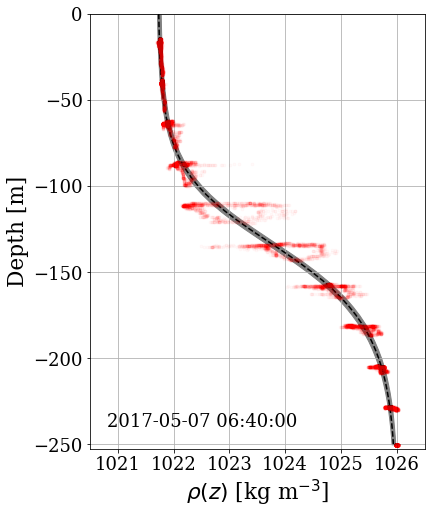

In [25]:
# Animate the density field with the observation
fig = plt.figure(figsize=(6,8))
ax=plt.gca()

tstep = 100
idx = timeidx == tstep

rho_min = np.percentile(rho[:,tstep,:],5,axis=-1)
rho_max = np.percentile(rho[:,tstep,:],95,axis=-1)
rho_50 = np.median(rho[:,tstep,:],axis=-1)

p1, = plt.plot(rho_50, z1d,'k--')
#p2, = plt.plot(ds.rho[tstep,:],ds.depth,'rd')
p2, = plt.plot(rhoobs[idx]*rho_std+rho_mu, zobs[idx]*z_std,'r.',alpha=0.02)
t1 = plt.text(0.05,0.05, ds.time.values[tstep].astype(str)[0:19].replace('T',' '), transform=ax.transAxes)

plt.grid(b=True)
plt.ylim(zmin,0)
plt.xlim(1020.5, 1026.5)
plt.ylabel('Depth [m]')
plt.xlabel(r'$\rho(z)$ [kg m$^{-3}$]')

def init():
    return t1,p1,p2

def animate(tstep):
    
    rho_min = np.percentile(rho[:,tstep,:],5,axis=-1)
    rho_max = np.percentile(rho[:,tstep,:],95,axis=-1)
    rho_50 = np.median(rho[:,tstep,:],axis=-1)
    
    t1.set_text( ds.time.values[tstep].astype(str)[0:19].replace('T',' '))
    
    idx = timeidx == tstep
    p2.set_xdata(rhoobs[idx]*rho_std+rho_mu)
    p2.set_ydata(zobs[idx]*z_std)
    #p2.set_xdata(ds.rho[tstep])
    p1.set_xdata(rho_50)
    
    ax.collections.clear()
    p3 = plt.fill_betweenx(z1d, rho_min, rho_max, color='0.5')

    return t1,p1,p2,p3,

    
ani = matplotlib.animation.FuncAnimation(fig, animate, init_func=init, frames=nt, blit=True)

ani.save('%s/rhoz_%s.mp4'%(outpath,sitename),writer='ffmpeg', fps=12)
